# 01 - EDA e Modelagem (FarmTech)

Este notebook contém:
- Leitura do dataset com colunas: Crop, Precipitation (mm day-1), Specific Humidity at 2 Meters (g/kg), Relative Humidity at 2 Meters (%), Temperature at 2 Meters (C), Yield
- Limpeza e normalização de nomes
- Análise exploratória (estatísticas, correlações, histogramas)
- Clusterização (KMeans) para identificar perfis ambientais
- Treinamento de 5 modelos de regressão (Linear, Decision Tree, Random Forest, XGBoost, SVR)
- Avaliação com RMSE, MAE e R²
- Geração de artefatos: `artifacts/metrics.csv` e `artifacts/feature_importances.png`

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import joblib


## 1) Carregar dados

A seguir carregamos o CSV `data/crop_yield.csv`. As colunas esperadas são:
- Crop
- Precipitation (mm day-1)
- Specific Humidity at 2 Meters (g/kg)
- Relative Humidity at 2 Meters (%)
- Temperature at 2 Meters (C)
- Yield

In [9]:
csv_path = "../data/crop_yield.csv"
df = pd.read_csv(csv_path)
print("Shape:", df.shape)
df.head()

Shape: (156, 6)


,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


## 2) Normalizar nomes de colunas e limpeza básica

Convertendo nomes para snake_case e convertendo colunas numéricas.
Usaremos como target a coluna `Yield`.

In [16]:
orig_cols = df.columns.tolist()
print("Colunas originais:", orig_cols)

def normalize_colname(col):
    return (col.strip()
               .replace(" ", "_")
               .replace("(", "")
               .replace(")", "")
               .replace("%", "pct")
               .replace("/", "_")
               .replace("-", "_")
               .replace(".", "")
               .replace("__", "_")
               .lower())

df.columns = [normalize_colname(c) for c in df.columns]

num_cols = [
    'relative_humidity_at_2_meters_pct',
    'temperature_at_2_meters_c',
    'yield'
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

df = df.drop_duplicates()
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df.describe().T

Colunas originais: ['crop', 'precipitation_mm_day_1', 'specific_humidity_at_2_meters_g_kg', 'relative_humidity_at_2_meters_pct', 'temperature_at_2_meters_c', 'yield']


,count,mean,std,min,25%,50%,75%,max
precipitation_mm_day_1,156.0,2486.498974,289.457914,1934.62,2302.99,2424.55,2718.08,3085.79
specific_humidity_at_2_meters_g_kg,156.0,18.203077,0.293923,17.54,18.03,18.27,18.40,18.70
relative_humidity_at_2_meters_pct,156.0,84.737692,0.996226,82.11,84.12,84.85,85.51,86.10
temperature_at_2_meters_c,156.0,26.183590,0.261050,25.56,26.02,26.13,26.30,26.81
yield,156.0,56153.096154,70421.958897,5249.00,8327.75,18871.00,67518.75,203399.00


## 3) Análise rápida (histogramas e correlações)

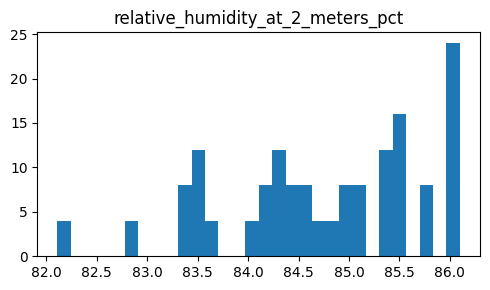

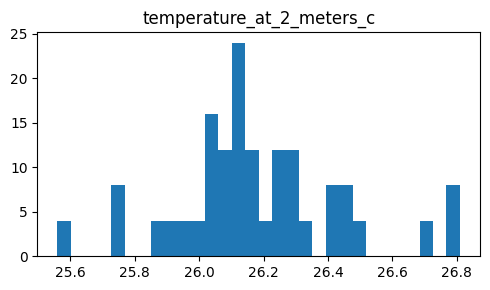

                                   relative_humidity_at_2_meters_pct  \
relative_humidity_at_2_meters_pct                           1.000000   
temperature_at_2_meters_c                                  -0.337313   
yield                                                       0.000008   

                                   temperature_at_2_meters_c     yield  
relative_humidity_at_2_meters_pct                  -0.337313  0.000008  
temperature_at_2_meters_c                           1.000000  0.013007  
yield                                               0.013007  1.000000  


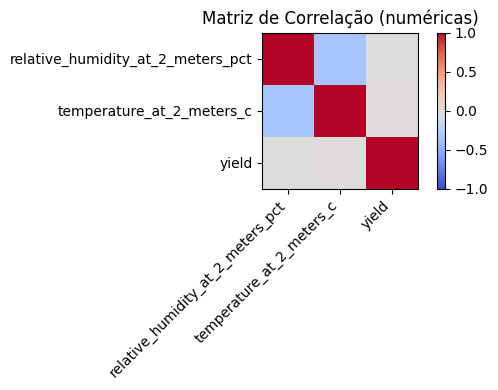

In [17]:
for c in num_cols[:-1]:
    plt.figure(figsize=(5,3))
    plt.hist(df[c].dropna(), bins=30)
    plt.title(c)
    plt.tight_layout()
    plt.show()

corr = df[num_cols].corr()
print(corr)
plt.figure(figsize=(6,4))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Matriz de Correlação (numéricas)")
plt.tight_layout()
plt.show()

## 4) Clusterização (KMeans) — identificar perfis ambientais

Usaremos as features numéricas (exceto yield) para segmentar em 3 clusters.

In [19]:
features_for_clustering = [
    'relative_humidity_at_2_meters_pct',
    'temperature_at_2_meters_c'
]
X = df[features_for_clustering].copy()
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(Xs)

centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=features_for_clustering)
print("Centros dos clusters (valores originais):")
display(centers_df)

Centros dos clusters (valores originais):


,relative_humidity_at_2_meters_pct,temperature_at_2_meters_c
0,85.657647,26.075294
1,84.456923,26.123846
2,83.405556,26.474444


## 5) Preparação para modelagem

- One-hot encode para 'crop' (se existente)
- Separar X e y
- Train/Test split
- Escalar features numéricas (salvar o scaler)

In [21]:
if 'crop' in df.columns:
    df = pd.get_dummies(df, columns=['crop'], drop_first=True)

target = 'yield'
X = df.drop(columns=[target])
y = df[target]

numeric_cols = X.select_dtypes(include=np.number).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler2 = StandardScaler()
X_train[numeric_cols] = scaler2.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler2.transform(X_test[numeric_cols])

joblib.dump(scaler2, "../models/scaler.joblib")
joblib.dump(list(X.columns), "../models/feature_order.joblib")
print("Preparação concluída. Formatos:", X_train.shape, X_test.shape)

Preparação concluída. Formatos: (124, 8) (32, 8)


## 6) Treinar 5 modelos e avaliar
Modelos:
- LinearRegression
- DecisionTreeRegressor
- RandomForestRegressor
- XGBRegressor
- SVR (RBF)

In [30]:
models = {
    'linear': LinearRegression(),
    'dt': DecisionTreeRegressor(random_state=42),
    'rf': RandomForestRegressor(n_estimators=200, random_state=42),
    'xgb': XGBRegressor(n_estimators=200, random_state=42, verbosity=0),
    'svr': SVR(kernel='rbf', C=1.0, epsilon=0.2)
}

results = []
for name, m in models.items():
    print(f"Treinando {name}...")
    m.fit(X_train, y_train)
    preds = m.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    joblib.dump(m, f"../models/{name}_model.joblib")
    results.append({'model': name, 'rmse': rmse, 'mae': mae, 'r2': r2})
    print(f"{name} RMSE={rmse:.3f} MAE={mae:.3f} R2={r2:.3f}")

res_df = pd.DataFrame(results).sort_values('rmse')
res_df.to_csv("../artifacts/metrics.csv", index=False)
display(res_df)

Treinando linear...
linear RMSE=4426.887 MAE=3155.582 R2=0.995
Treinando dt...
dt RMSE=6767.607 MAE=3448.625 R2=0.988
Treinando rf...
rf RMSE=4709.876 MAE=2684.298 R2=0.994
Treinando xgb...
rf RMSE=4709.876 MAE=2684.298 R2=0.994
Treinando xgb...
xgb RMSE=6450.570 MAE=3832.256 R2=0.989
Treinando svr...
svr RMSE=71312.308 MAE=38972.548 R2=-0.311
xgb RMSE=6450.570 MAE=3832.256 R2=0.989
Treinando svr...
svr RMSE=71312.308 MAE=38972.548 R2=-0.311


,model,rmse,mae,r2
0,linear,4426.887308,3155.581850,0.994948
2,rf,4709.876263,2684.297656,0.994281
3,xgb,6450.569824,3832.255615,0.989273
1,dt,6767.606939,3448.625000,0.988193
4,svr,71312.308096,38972.547556,-0.311029


## 7) Feature importances (se disponível para o modelo escolhido)

Se o modelo (ex.: Random Forest ou XGBoost) expõe importâncias, gere gráfico e salve em `artifacts/feature_importances.png`.

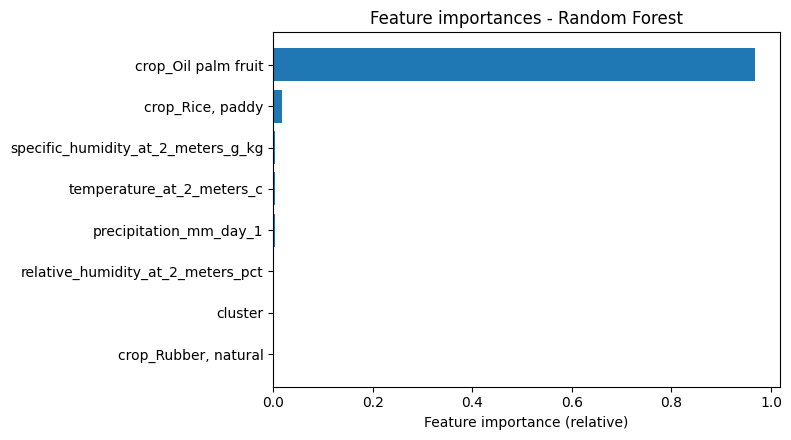

In [32]:
try:
    rf = joblib.load("../models/rf_model.joblib")
    if hasattr(rf, "feature_importances_"):
        fi = rf.feature_importances_
        cols = X_train.columns.tolist()
        idx = np.argsort(fi)[::-1]
        plt.figure(figsize=(8,4.5))
        plt.barh([cols[i] for i in idx], fi[idx])
        plt.gca().invert_yaxis()
        plt.xlabel("Feature importance (relative)")
        plt.title("Feature importances - Random Forest")
        plt.tight_layout()
        plt.savefig("../artifacts/feature_importances.png")
        plt.show()
    else:
        print("Modelo RF não contém attribute feature_importances_")
except Exception as e:
    print("Não foi possível gerar feature importances:", e)